<a href="https://colab.research.google.com/github/Michel93DM/Deep-Learning---Score-Based-Models/blob/main/GAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d

import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10

import numpy as np
import matplotlib.pyplot as plt


import matplotlib.animation as animation
from IPython.display import HTML



from PIL import Image
import sys
import os
import time

In [2]:
print(torch.__version__)
print('GPU Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

print(device)

2.0.0+cu118
GPU Available: False
cpu


In [3]:
transform =  transforms.Compose([ transforms.ToTensor(),
                               transforms.Normalize(mean= (0.5),std = (0.5)), ])

FashionMNIST_data = FashionMNIST('.', train=True, 
                                 transform=transforms.ToTensor(), download=True)


example1, label1 = next(iter(FashionMNIST_data))
print(f'Min: {example1.min() } Max : {example1.max()}')
print(example1.shape)

100%|██████████| 26421880/26421880 [00:00<00:00, 116028039.20it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5675019.83it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60372698.65it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15511693.24it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Min: 0.0 Max : 1.0
torch.Size([1, 28, 28])


In [4]:
## define a function for the generator:

def make_generator_network(input_size= 20, 
                           num_hidden_layers = 1, 
                           num_hidden_units = 100,
                           num_output_units = 784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}',
                     nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}',nn.LeakyReLU())
    input_size = num_hidden_units

  model.add_module(f'fc_g{num_hidden_layers}', 
                   nn.Linear(input_size, num_output_units))
  model.add_module('tanh_g', nn.Tanh())

  return model

## define a function for the discrimainator: 

def make_discriminator_network(input_size, 
                               num_hidden_layers =1, 
                               num_hidden_units = 100, 
                               num_output_units = 1 ):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}',
                     nn.Linear(input_size, num_hidden_units, bias = False))
    model.add_module(f'relu_d{i}', nn.LeakyReLU())
    model.add_module('dropout', nn.Dropout(p=0.5))
    input_size = num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', 
                   nn.Linear(input_size, num_output_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model

In [5]:
image_size = (28,28)
z_size = 20
gen_hidden_layers  = 1
disc_hidden_layers  = 1
gen_hidden_size    = 100
disc_hidden_size = 100
torch.manual_seed(1)

gen_model = make_generator_network( input_size= z_size, num_hidden_layers= gen_hidden_layers,
                                   num_hidden_units= gen_hidden_size,
                                   num_output_units= np.prod(image_size)
                                   )

print(gen_model)

disc_model = make_discriminator_network( input_size=np.prod(image_size),
                                        num_hidden_layers= disc_hidden_layers,
                                        num_hidden_units= disc_hidden_size
                                        )

print(disc_model)


Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [6]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size)*2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z
                                                     

In [7]:
from torch.utils.data import DataLoader

batch_size = 32

dataloader = DataLoader( FashionMNIST_data, batch_size, shuffle = False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z --shape:', input_z.shape)
print('input-real --shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z --shape: torch.Size([32, 20])
input-real --shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [8]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
FashionMNIST_dl = DataLoader(FashionMNIST_data, batch_size, shuffle = False)

gen_model = make_generator_network( input_size= z_size, num_hidden_layers= gen_hidden_layers,
                                   num_hidden_units= gen_hidden_size,
                                   num_output_units= np.prod(image_size)
                                   ).to(device)

disc_model = make_discriminator_network( input_size=np.prod(image_size),
                                        num_hidden_layers= disc_hidden_layers,
                                        num_hidden_units= disc_hidden_size
                                        ).to(device)

loss_fn = nn.BCELoss()
d_optimizer = optim.Adam(disc_model.parameters())
g_optimizer = optim.Adam(gen_model.parameters())

In [9]:
def d_train(x):
    disc_model.zero_grad()
    
    batch_size = x.size(0)
    x= x.view(batch_size, -1).to(device)
    
    d_labels_real = torch.ones(batch_size,1,device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    
    # Train D on fake data
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size,1,device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    
    d_loss = d_loss_real + d_loss_fake
    
    d_loss.backward()
    d_optimizer.step()
     
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size,mode_z).to(device)
    g_labels_real = torch.ones(batch_size,1,device=device)
    
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    #gradient backprop & optimize only G's parametrs
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss.data.item()

In [11]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    #fake_display = g_model(input_z).detach().cpu()
    return (images + 1)/2.0

epoch_samples =[]
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 30

for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(FashionMNIST_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
    
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | AVG Losses >>'
          f'G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f'[D-Real {all_d_real[-1]:.4f}'
          f'D-Fake= {all_d_fake[-1]:.4f}]')
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())
      

Epoch 001 | AVG Losses >>G/D 0.9393/1.2339[D-Real 0.5522D-Fake= 0.4298]
Epoch 002 | AVG Losses >>G/D 0.8526/1.2953[D-Real 0.5353D-Fake= 0.4512]
Epoch 003 | AVG Losses >>G/D 0.8485/1.3095[D-Real 0.5349D-Fake= 0.4613]
Epoch 004 | AVG Losses >>G/D 0.8492/1.3059[D-Real 0.5343D-Fake= 0.4583]
Epoch 005 | AVG Losses >>G/D 0.8945/1.2447[D-Real 0.5672D-Fake= 0.4456]
Epoch 006 | AVG Losses >>G/D 0.9460/1.2023[D-Real 0.5836D-Fake= 0.4262]
Epoch 007 | AVG Losses >>G/D 0.8935/1.2795[D-Real 0.5492D-Fake= 0.4414]
Epoch 008 | AVG Losses >>G/D 0.9460/1.2131[D-Real 0.5822D-Fake= 0.4291]
Epoch 009 | AVG Losses >>G/D 0.9595/1.2207[D-Real 0.5787D-Fake= 0.4230]
Epoch 010 | AVG Losses >>G/D 0.9514/1.2303[D-Real 0.5704D-Fake= 0.4258]
Epoch 011 | AVG Losses >>G/D 0.9681/1.2100[D-Real 0.5816D-Fake= 0.4200]
Epoch 012 | AVG Losses >>G/D 0.9561/1.2166[D-Real 0.5784D-Fake= 0.4216]
Epoch 013 | AVG Losses >>G/D 0.9892/1.2130[D-Real 0.5805D-Fake= 0.4184]
Epoch 014 | AVG Losses >>G/D 0.9984/1.2076[D-Real 0.5841D-Fake= 

Text(0, 0.5, 'Loss')

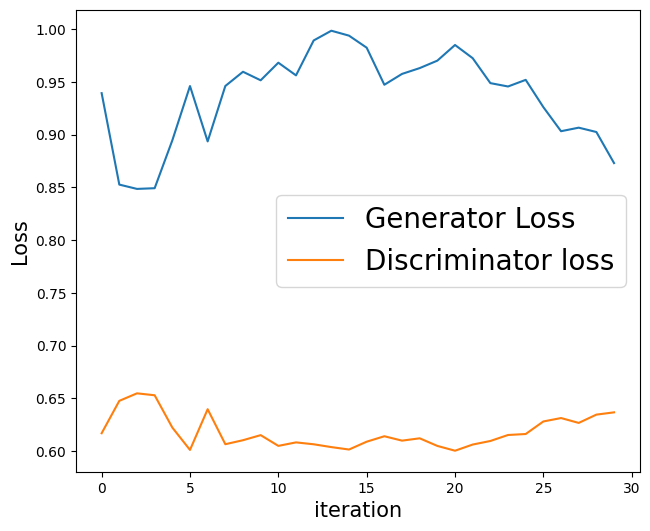

In [12]:
import itertools
fig = plt.figure(figsize= (16,6))
#plotting the losses

ax= fig.add_subplot(1,2,1)

plt.plot(all_g_losses, label = 'Generator Loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label = 'Discriminator loss')
plt.legend (fontsize = 20)
ax.set_xlabel('iteration', size = 15)
ax.set_ylabel('Loss', size = 15)



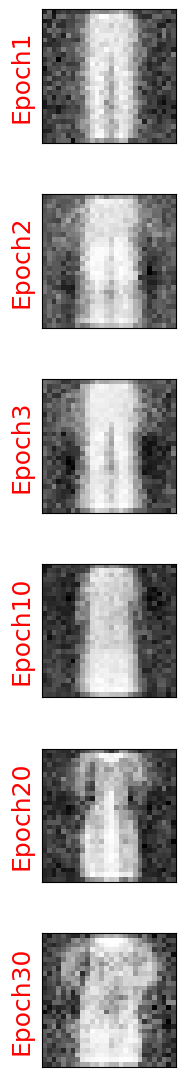

In [33]:
selected_epochs = [1, 2, 3 ,10, 20, 30 ]
fig = plt.figure(figsize = (10,14))

for i, e in enumerate (selected_epochs):
  for j in range(1):
    ax = fig.add_subplot(6,5,i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoch{e}',
          rotation = 90, size = 18, color ='red',
          horizontalalignment = 'right',
          verticalalignment = 'center',
          transform = ax.transAxes
      ) 
      image = epoch_samples[e-1][j]
      ax.imshow(image, cmap='gray')

plt.show()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    fake_display = g_model(input_z).detach().cpu()
    return fake_display